In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rohitgr/wikitext")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\rohitgr\wikitext\versions\1


In [2]:
!pip install torchtext==0.6.0


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, Vocab
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

In [4]:
root = Path(path) / "wikitext-103"

train_dir = root / "wiki.train.tokens"
valid_dir  = root / "wiki.valid.tokens"

SKIPGRAM_N_WORDS = 2
MIN_WORD_FREQUENCY = 5
MAX_SEQUENCE_LENGTH = 256

EMBED_DIM = 256
EMBED_MAX_NORM = 1
BATCH_SIZE = 128

In [5]:
tokenizer = get_tokenizer("basic_english", language="en")

def load_and_preprocess_dataset(path):
    with open(path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    data = list(filter(
        lambda sent: len(sent) > SKIPGRAM_N_WORDS * 2,
        map(tokenizer, lines)
    ))
    return data

In [6]:
train_data = load_and_preprocess_dataset(train_dir)
valid_data = load_and_preprocess_dataset(valid_dir)

total_train_tokens = sum(len(sent) for sent in train_data)
total_valid_tokens = sum(len(sent) for sent in valid_data)

print(f'Num sentences: train - {len(train_data)}, valid - {len(valid_data)}')
print(f'Total tokens: train - {total_train_tokens}, valid - {total_valid_tokens}')
print(f'Average tokens in sentence: {total_train_tokens / len(train_data):.2f}')

Num sentences: train - 1125664, valid - 2391
Total tokens: train - 101431047, valid - 214347
Average tokens in sentence: 90.11


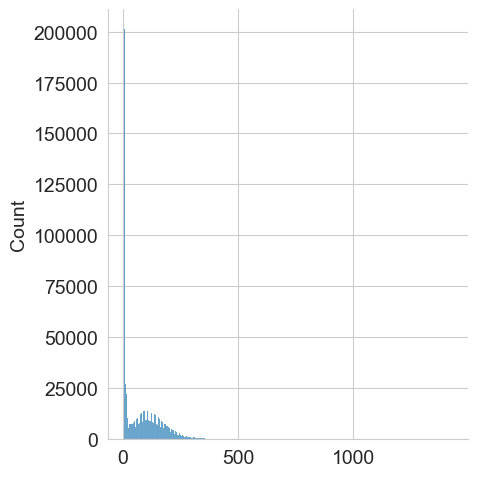

In [7]:
_ = sns.displot([len(sent) for sent in train_data])

In [8]:
counter = Counter(token for sent in train_data for token in sent)
len(counter)

226763

In [9]:
vocab = Vocab(counter, min_freq=MIN_WORD_FREQUENCY, specials=['<unk>'])

VOCAB_SIZE = len(vocab)
print(f'Vocab size: {VOCAB_SIZE}')

Vocab size: 166769


In [10]:
train_data[42] # spróbuj dać indeks 200

['perhaps',
 'because',
 'abraham',
 'lincoln',
 'had',
 'not',
 'yet',
 'been',
 'inaugurated',
 'as',
 'president',
 ',',
 'captain',
 'totten',
 'received',
 'no',
 'instructions',
 'from',
 'his',
 'superiors',
 'and',
 'was',
 'forced',
 'to',
 'withdraw',
 'his',
 'troops',
 '.',
 'he',
 'agreed',
 'to',
 'surrender',
 'the',
 'arsenal',
 'as',
 'long',
 'as',
 'the',
 'governor',
 'agreed',
 'to',
 'three',
 'provisions']

In [11]:
[vocab[token] for token in train_data[42]] # i potem tu też daj 200

[1989,
 145,
 6791,
 2303,
 31,
 38,
 1017,
 52,
 11020,
 15,
 366,
 2,
 715,
 62740,
 188,
 83,
 5667,
 28,
 24,
 13842,
 5,
 10,
 714,
 7,
 4138,
 24,
 642,
 3,
 26,
 975,
 7,
 3058,
 1,
 2556,
 15,
 160,
 15,
 1,
 846,
 975,
 7,
 74,
 5102]

In [12]:
def sent_to_idx(sent):
    return [vocab[token] for token in sent]


def collate_fn(batch):
    """
    Collate_fn for Skip-Gram model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.

    Context is represented as N=SKIPGRAM_N_WORDS past words 
    and N=SKIPGRAM_N_WORDS future words.

    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.

    Each element in `batch_input` is a middle word.
    Each element in `batch_output` is a context word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = sent_to_idx(text)

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - SKIPGRAM_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + SKIPGRAM_N_WORDS * 2 + 1)]
            input_ = token_id_sequence.pop(SKIPGRAM_N_WORDS)
            outputs = token_id_sequence

            batch_input += [input_] * len(outputs)
            batch_output += outputs

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output

In [13]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=0,
                          pin_memory=True, collate_fn=collate_fn, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=0,
                          pin_memory=True, collate_fn=collate_fn)

In [14]:
from IPython.display import clear_output
from tqdm.notebook import tqdm


def plot_losses(train_losses, valid_losses):
    clear_output()
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='valid', color='springgreen', linewidth=2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, num_batches = 0.0, 1
    model.train()
    for inputs, pos_outputs in tqdm(train_loader, desc=tqdm_desc):
        inputs = inputs.to(device)
        pos_outputs = pos_outputs.to(device)
        neg_outputs = torch.randint_like(inputs, low=0, high=VOCAB_SIZE)

        input_emb = model.encoder(inputs)
        pos_output_emb = model.decoder(pos_outputs)
        neg_output_emb = model.decoder(neg_outputs)

        optimizer.zero_grad()
        pos_sim = (input_emb * pos_output_emb).sum(1)
        neg_sim = (input_emb * neg_output_emb).sum(1)

        loss = criterion(pos_sim, torch.ones(pos_sim.shape, device=device)) + \
               criterion(neg_sim, torch.zeros(neg_sim.shape, device=device))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        num_batches += 1

    train_loss /= num_batches
    return train_loss


@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, tqdm_desc):
    valid_loss, num_batches = 0.0, 0
    model.eval()
    for inputs, pos_outputs in tqdm(valid_loader, desc=tqdm_desc):
        inputs = inputs.to(device)
        pos_outputs = pos_outputs.to(device)
        neg_outputs = torch.randint_like(inputs, low=0, high=VOCAB_SIZE)

        input_emb = model.encoder(inputs)
        pos_output_emb = model.decoder(pos_outputs)
        neg_output_emb = model.decoder(neg_outputs)

        pos_sim = (input_emb * pos_output_emb).sum(1)
        neg_sim = (input_emb * neg_output_emb).sum(1)

        loss = criterion(pos_sim, torch.ones(pos_sim.shape, device=device)) + \
               criterion(neg_sim, torch.zeros(neg_sim.shape, device=device))

        valid_loss += loss.item()
        num_batches += 1

    valid_loss /= num_batches
    return valid_loss


def train(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    train_losses, valid_losses = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss = validation_epoch(
            model, criterion, valid_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        valid_losses += [valid_loss]
        plot_losses(train_losses, valid_losses)

In [17]:
class Word2VecModel(nn.Module):
    def __init__(self, embed_dim, embed_max_norm, vocab_size):
        super().__init__()
        self.encoder = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim,
                                    max_norm=embed_max_norm)
        self.decoder = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)

In [20]:
NUM_EPOCHS = 3
model = Word2VecModel(embed_dim=EMBED_DIM, embed_max_norm=EMBED_MAX_NORM,
                      vocab_size=VOCAB_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)
criterion = nn.BCEWithLogitsLoss()

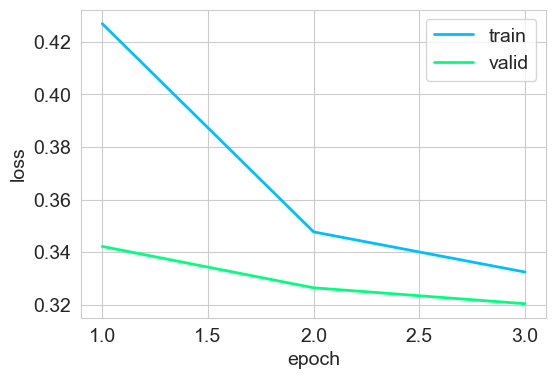

In [21]:
train(model, optimizer, scheduler, criterion, train_loader, valid_loader, NUM_EPOCHS)

In [22]:
import re


def get_similarities(embed_vector):
    similarities = embed_matrix @ embed_vector / embed_norms / torch.norm(embed_vector)
    top_indices = similarities.argsort(descending=True)
    return similarities, top_indices


def get_similar(query, num_similar=5):
    print(f'Processing query \"{query}\"')
    split_query = re.split('([^a-zA-Z0-9])', query)
    index = vocab[split_query[0]]
    embed_vector = torch.clone(embed_matrix[index])
    if index > 0:
        print(f'Found word \"{split_query[0]}\" in vocab')
    else:
        print(f'Word \"{split_query[0]}\" not in vocab, using <unk>')

    for i in range(2, len(split_query), 2):
        index = vocab[split_query[i]]
        if index > 0:
            print(f'Found word \"{split_query[i]}\" in vocab, ', end='')
        else:
            print(f'Word \"{split_query[i]}\" not in vocab, using <unk>, ', end='')
        print(f'operation \"{split_query[i - 1]}\"')

        if split_query[i - 1] == '+':
            embed_vector += embed_matrix[index]
        elif split_query[i - 1] == '-':
            embed_vector -= embed_matrix[index]
        else:
            raise ValueError('Unknown operation')

    similarities, top_indices = get_similarities(embed_vector)
    print('Top similar:')
    for top_index in top_indices[:num_similar]:
        print(f'    {vocab.itos[top_index]}: sim = {similarities[top_index]:.4f}')

In [23]:
embed_matrix = model.encoder.weight.detach()
embed_norms = (embed_matrix ** 2).sum(1).sqrt()

In [24]:
get_similar('king', num_similar=10)

Processing query "king"
Found word "king" in vocab
Top similar:
    king: sim = 1.0000
    son: sim = 0.7223
    reign: sim = 0.7175
    emperor: sim = 0.7130
    henry: sim = 0.7029
    regent: sim = 0.6983
    prince: sim = 0.6958
    brother: sim = 0.6926
    president: sim = 0.6840
    edward: sim = 0.6706


In [25]:
get_similar('woman', num_similar=10)

Processing query "woman"
Found word "woman" in vocab
Top similar:
    woman: sim = 1.0000
    girl: sim = 0.7697
    really: sim = 0.7520
    character: sim = 0.7519
    man: sim = 0.7439
    something: sim = 0.7433
    herself: sim = 0.7422
    someone: sim = 0.7391
    mother: sim = 0.7390
    always: sim = 0.7348


In [26]:
get_similar('fork', num_similar=10)

Processing query "fork"
Found word "fork" in vocab
Top similar:
    fork: sim = 1.0000
    watershed: sim = 0.6349
    located: sim = 0.6224
    tributaries: sim = 0.6097
    streams: sim = 0.6086
    upper: sim = 0.6085
    ranges: sim = 0.6068
    northernmost: sim = 0.6059
    crest: sim = 0.6005
    thick: sim = 0.5981


In [27]:
get_similar('queen-woman+man', num_similar=10)

Processing query "queen-woman+man"
Found word "queen" in vocab
Found word "woman" in vocab, operation "-"
Found word "man" in vocab, operation "+"
Top similar:
    queen: sim = 0.7932
    man: sim = 0.6258
    rickards: sim = 0.5520
    butterfield: sim = 0.5382
    fortesque: sim = 0.5129
    bratman: sim = 0.5109
    gooch: sim = 0.5078
    fleitz: sim = 0.5075
    daggett: sim = 0.5059
    schwimmer: sim = 0.5050


In [28]:
get_similar('king-man+woman', num_similar=10)

Processing query "king-man+woman"
Found word "king" in vocab
Found word "man" in vocab, operation "-"
Found word "woman" in vocab, operation "+"
Top similar:
    king: sim = 0.8451
    emperor: sim = 0.6358
    son: sim = 0.6339
    father: sim = 0.6085
    brother: sim = 0.6044
    reign: sim = 0.5987
    successor: sim = 0.5959
    governor: sim = 0.5939
    prince: sim = 0.5930
    wife: sim = 0.5914
